In [1]:
import numpy as np
import pandas as pd
import numpy.random as rgt
from scipy.stats import norm
from scipy.optimize import fsolve
from selectinf.base import selected_targets
from selectinf.QR_lasso import QR_lasso
from selectinf.randomization import randomization
from selectinf.approx_reference import approximate_grid_inference
from selectinf.exact_reference import exact_grid_inference
from selectinf.regreg_QR.QR_population import *

# set random seed
np.random.seed(2023)
np.set_printoptions(threshold=np.inf)

In [2]:
# generate covariance matrix
def cov_generate(std, rho):
    p = len(std)
    R = np.abs(np.subtract.outer(np.arange(p), np.arange(p)))
    return np.outer(std, std) * (rho ** R)

# estimate AR covariance matrix
def cov_estmate(X, t = 100):
    ARrho = []
    for s in np.random.sample(t):
        Xr = X[int(s * n)]
        ARrho.append(np.corrcoef(Xr[1:], Xr[:-1])[0, 1])
    ARrho = np.mean(ARrho)
    ARcov = ARrho ** (np.abs(np.subtract.outer(np.arange(p), np.arange(p))))
    return ARcov

# Homogeneous model

$$
    y_i= \boldsymbol{x}_i ^ \top \boldsymbol{\beta}^* + \varepsilon_i-F_{\varepsilon_i}^{-1}(\tau)
$$

For our targets, we consider two different targets for implement purpose:
1. the first target solves population smoothed quantile loss function
2. the second target solves check loss function


Next, we focus on the details about first target.
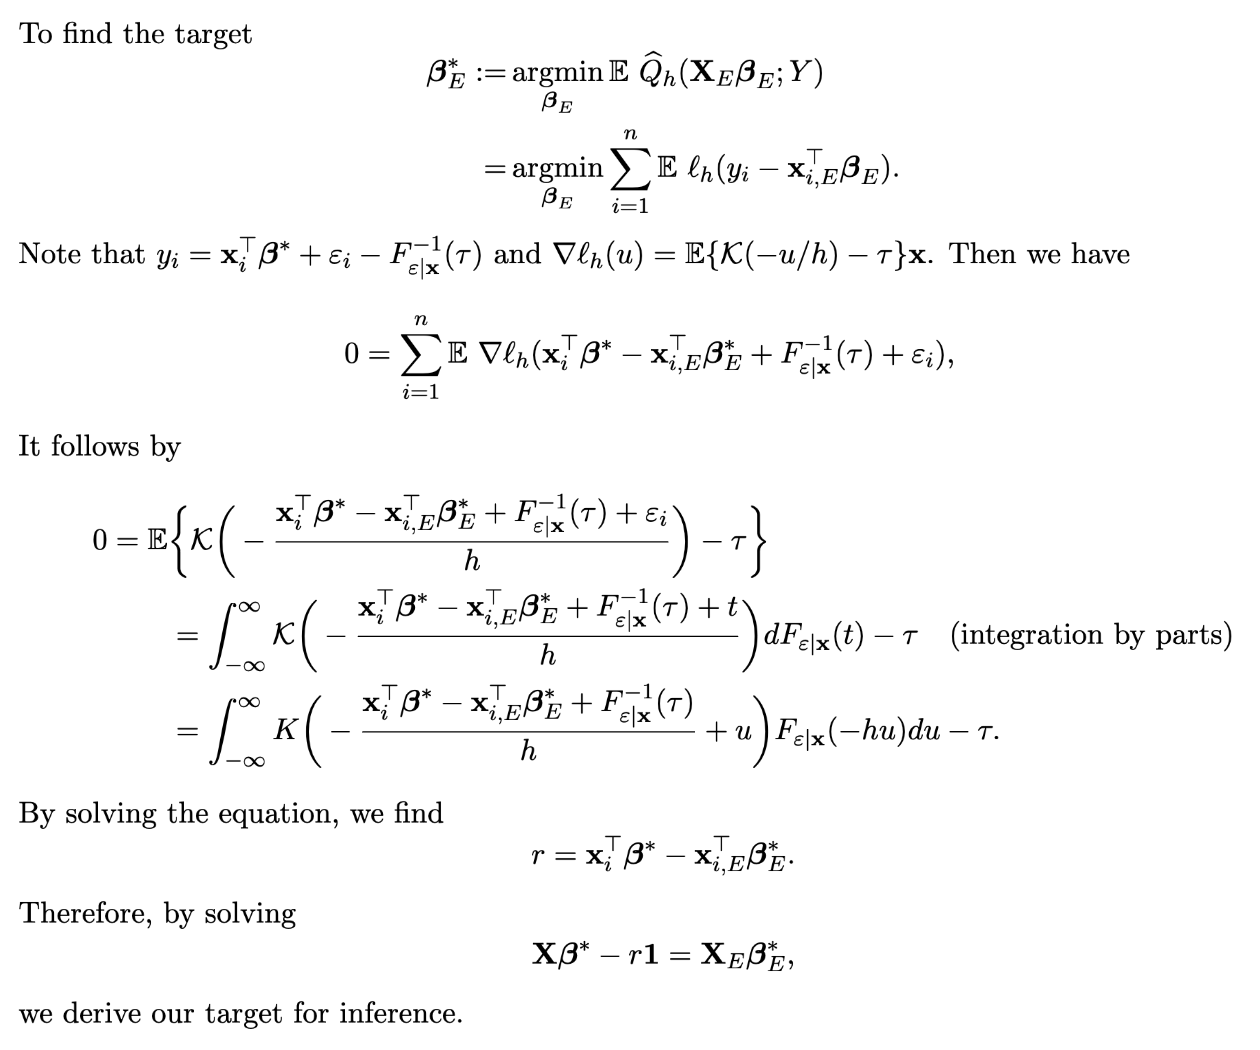

In [3]:
# model setting
num_set = []
coverage_exact1 = []
coverage_exact2 = []
coverage_approx1 = []
coverage_approx2 = []
length_exact = []
length_approx = []

n, p = 800, 200
mu, Sig = np.zeros(p), cov_generate(np.ones(p), 0.5)
beta = np.zeros(p)
beta[0:5] = 1
tau = 0.75

In [4]:
reps = 500
for i in range(reps):
    print(i)
    # generate sample
    X = rgt.multivariate_normal(mean=mu, cov=Sig, size=n)
    Y = X.dot(beta) + rgt.normal(loc=0, scale=1, size=n) - norm.ppf(tau, loc=0, scale=1)

    # inference
    randomizer = randomization.isotropic_gaussian(shape=(p,), scale=0.75*(1/np.sqrt(n)))
    conv = QR_lasso(X,
                    Y,
                    tau=tau,
                    randomizer=randomizer)
    conv.fit()
    conv.setup_inference()
    query_spec = conv.specification
    target_spec, bw = selected_targets(X,
                                       Y,
                                       tau=tau,
                                       solution=conv.observed_soln)

    # nonzero set of penalized estimator
    nonzero_set = np.nonzero(conv.observed_soln)[0]
    num_set.append(nonzero_set.size)
    print(conv.observed_soln[nonzero_set])
    print(target_spec.observed_target)

    # beta target    
    value = fsolve(find_root, 0, args=(tau, bw, 'Gaussian'))
    beta_target1 = np.linalg.pinv(X[:, nonzero_set]).dot(X.dot(beta) - value)
    beta_target2 = np.linalg.pinv(X[:, nonzero_set]).dot(X.dot(beta))
    print(beta_target1)
    print(beta_target2)

    # exact pivot
    exact_grid_inf = exact_grid_inference(query_spec, target_spec)
    lci, uci = exact_grid_inf._intervals(level=0.90)
    length = uci - lci
    coverage1 = (lci < beta_target1) * (uci > beta_target1)
    coverage2 = (lci < beta_target2) * (uci > beta_target2)
    coverage_exact1.append(np.mean(coverage1))
    coverage_exact2.append(np.mean(coverage2))
    length_exact.append(np.mean(length))

    # approximate pivot
    approximate_grid_inf = approximate_grid_inference(query_spec, target_spec)
    lci, uci = approximate_grid_inf._intervals(level=0.90)
    length = uci - lci
    coverage1 = (lci < beta_target1) * (uci > beta_target1)
    coverage2 = (lci < beta_target2) * (uci > beta_target2)
    coverage_approx1.append(np.mean(coverage1))
    coverage_approx2.append(np.mean(coverage2))
    length_approx.append(np.mean(length))


0
[0.771442   0.74713877 1.07388299 0.74631389 0.83287475]
[1.05837666 0.96434992 1.00813981 1.04135739 0.97669037]
[1.00052753 1.0001328  0.99957062 0.99965612 0.9998223 ]
[1. 1. 1. 1. 1.]
1
[ 0.82814313  1.03301844  0.88641203  0.72890543  0.92291869 -0.01239106]
[ 1.01794667  1.03965847  0.91568314  0.96665977  1.12240451 -0.02425444]
[9.99785121e-01 9.99800350e-01 9.99853583e-01 1.00049648e+00
 9.99553016e-01 2.09973646e-04]
[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 2.56739074e-16]
2
[0.44110041 1.13334439 0.92128023 0.71229868 0.96168491 0.0756806
 0.02903409]
[0.91527746 1.00336461 1.00868571 0.95898846 1.02623068 0.01766011
 0.07556989]
[ 9.99483685e-01  1.00028956e+00  9.99855886e-01  1.00029171e+00
  1.00029449e+00  3.77758624e-04 -7.66717158e-04]
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00 -1.38777878e-16  1.97758476e-16]
3
[0.77023917 0.91145838 0.66825379 1.26040377 0.58658546 0.0369618 ]
[1.00280018 1

[ 1.00042141e+00  9.99167221e-01  9.99550903e-01  9.99987108e-01
  1.00009006e+00 -1.92644507e-04 -2.08307620e-04]
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.78676518e-16 -1.24900090e-16]
26
[ 0.68616356  1.03740034  0.96098482  0.75839717  0.82315299 -0.04094918]
[ 0.96964118  0.97439583  0.9789171   1.05944644  0.96727034 -0.09180006]
[ 1.00024245e+00  1.00027195e+00  1.00009991e+00  9.99796021e-01
  1.00030798e+00 -6.70048856e-04]
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00 -4.71844785e-16]
27
[ 5.59506748e-01  1.18386318e+00  9.01990488e-01  1.00649352e+00
  6.32566982e-01  2.48177373e-03 -9.82059983e-04  1.05568504e-02]
[0.98651506 1.05536367 1.06998632 0.96276919 0.91104018 0.00535207
 0.00480274 0.05266259]
[ 9.99969277e-01  9.99678472e-01  1.00071672e+00  9.99630951e-01
  1.00061420e+00  6.99341758e-05  1.70109779e-04 -1.37022125e-04]
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00


[9.99893474e-01 9.99813793e-01 9.99723228e-01 1.00064773e+00
 9.99502450e-01 2.48554008e-04]
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00 -2.91433544e-16]
50
[0.86542025 0.85821785 0.93770301 1.00903873 0.91488895 0.02678363
 0.00667201 0.03793246]
[0.93481668 1.04598289 0.98101068 1.05093213 0.99162236 0.01990852
 0.09903173 0.07061951]
[ 9.99902925e-01  1.00082376e+00  1.00007353e+00  9.99651071e-01
  9.99439135e-01  7.52160480e-04 -2.64711067e-05 -4.87633099e-04]
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  8.60422844e-16  3.95516953e-16 -1.53523028e-16]
51
[0.90921028 0.94799916 0.81526955 0.8297206  0.82220074]
[1.04940475 0.9467682  0.90146777 0.9835054  1.0608517 ]
[0.99955508 1.00054012 1.00003835 1.00042397 0.99985063]
[1. 1. 1. 1. 1.]
52
[0.71759489 0.9588348  1.08971702 0.77372527 0.87296076 0.01733285]
[0.98422182 1.0079005  1.10983524 1.03976581 0.92014521 0.11476135]
[1.00045095e+00 9.99970206e-01 

75
[ 0.86424486  0.99680228  0.7074497   0.92443186  0.82826723 -0.01558233
 -0.06221881 -0.14289178]
[ 1.02064659  1.03317225  0.98030033  1.01677321  1.00339872 -0.04525397
 -0.12530027  0.01787424]
[ 9.99702398e-01  9.99960943e-01  9.99997718e-01  9.99794052e-01
  9.99882107e-01 -4.62939207e-05  1.17507863e-04  5.91152627e-04]
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00 -2.89698820e-16  1.17961196e-16 -8.32667268e-17]
76
[ 0.73314416  1.0207972   0.82987462  0.99098328  0.85907378  0.00427274
 -0.03239563]
[ 0.95025271  1.02582187  1.0551257   0.99762883  0.99640709  0.00837781
 -0.00955158]
[ 9.99741356e-01  9.99897444e-01  1.00022772e+00  9.99083434e-01
  1.00071297e+00 -6.11508650e-04  3.15157802e-04]
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00 -1.17961196e-16 -4.35415592e-16]
77
[0.80189295 0.96767363 1.02171151 0.8234401  0.81673222 0.00270348
 0.00263825]
[0.99261451 0.99345927 1.00863282 1.01871587 1.

98
[ 0.95869604  0.90951241  0.62810436  1.08339997  0.72526824 -0.0208014 ]
[1.01211497 0.9393131  1.01232191 1.02375717 1.1212465  0.01229929]
[ 9.99971365e-01  9.99945363e-01  1.00043512e+00  9.99694073e-01
  1.00059498e+00 -2.66286746e-04]
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00 -3.19796273e-15]
99
[0.93253556 0.72914708 0.9278873  0.93248273 0.9859777  0.00912713]
[0.97535817 1.00750168 1.05769158 1.00024259 1.03652258 0.05452166]
[1.00063731e+00 9.99835323e-01 1.00032935e+00 1.00046127e+00
 9.99944026e-01 6.70010995e-04]
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00 -3.33066907e-16]
100
[0.77888913 0.99835578 0.61305477 1.15222459 0.51495016]
[1.04077939 1.03176217 0.98405427 1.02430272 0.9915243 ]
[0.99971808 0.99979908 1.00031843 0.99993611 1.00011082]
[1. 1. 1. 1. 1.]
101
[ 0.65977763  0.88087963  0.75084361  0.93648937  0.87134203 -0.01614485]
[ 0.97415766  1.04106306  0.9394898   0.94013941  1.0864

125
[ 0.78881377  1.10014606  0.39110844  1.24116381  0.72409953  0.13068907
 -0.08143216]
[ 0.96153195  1.01433433  0.87609293  1.03087989  1.03311352  0.0948905
 -0.04585204]
[ 1.00058157e+00  9.99934514e-01  9.98751694e-01  1.00083380e+00
  9.99682477e-01  7.21134039e-04 -4.42038920e-04]
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00 -7.53737350e-16 -3.33066907e-16]
126
[0.78862459 0.94406868 0.93504514 0.70253746 0.92858216]
[1.04969528 1.02430052 0.96463645 0.9668108  1.02723549]
[0.9996062  1.00045848 0.99979825 1.00008525 1.00047404]
[1. 1. 1. 1. 1.]
127
[1.22730229 0.72941833 0.48637793 1.32634862 0.46942652]
[1.05427481 0.98849763 1.00595846 0.99656444 0.95045595]
[1.00012883 1.00030136 0.99993477 0.99965516 0.99979811]
[1. 1. 1. 1. 1.]
128
[ 1.04297048  0.71197834  0.91433057  0.8186749   1.0719416   0.01171116
 -0.03138898]
[ 1.03123734  0.91337553  1.0815466   1.03919731  0.99141354  0.00280439
 -0.03478729]
[ 1.00004283e+00  1.00016661e+0

151
[ 0.93782085  0.67159683  0.80429929  0.85858711  1.04009473 -0.01147043
  0.01432426]
[ 9.68678987e-01  9.56151935e-01  1.04691032e+00  1.02955311e+00
  1.05019524e+00 -8.45914100e-04  6.43625777e-02]
[9.99863453e-01 1.00020526e+00 9.99372660e-01 1.00078394e+00
 9.99313847e-01 2.99117397e-04 2.53613239e-05]
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  0.00000000e+00 -2.77555756e-17]
152
[ 0.51145876  1.10592592  0.79157973  1.09468594  0.77412947 -0.06345147]
[ 0.96550492  1.0131989   0.97448313  1.02181006  0.96070601 -0.00199242]
[ 9.99486200e-01  1.00039567e+00  9.99800082e-01  9.99956935e-01
  1.00020012e+00 -4.72490619e-04]
[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 9.02056208e-17]
153
[0.95759885 0.74523851 1.12344852 0.91888496 0.59147714]
[1.00618849 0.96250963 1.08434699 1.0079519  0.95600342]
[1.00033514 0.99980891 0.99983884 1.00037517 0.99990038]
[1. 1. 1. 1. 1.]
154
[0.91036109 0.63653973 1.021552

179
[ 0.90586139  0.95201279  0.89212988  0.89113069  0.82787473 -0.02209074]
[ 1.0048014   0.99468166  1.0441045   0.93330749  1.00958338 -0.10538314]
[9.99989670e-01 9.99948560e-01 9.99947967e-01 1.00092366e+00
 9.98854694e-01 3.79468304e-04]
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00 -1.82145965e-17]
180
[ 0.77727465  0.86445662  1.07679626  0.75143869  0.88659726  0.03420056
 -0.01275811]
[ 1.06911624  0.96886408  0.95307154  1.05894173  1.01570569  0.02528768
 -0.00138954]
[ 9.99986822e-01  9.99658524e-01  9.99756770e-01  1.00001191e+00
  1.00014942e+00 -5.51938070e-04 -2.56003017e-04]
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00 -4.85722573e-16 -2.22044605e-16]
181
[ 0.66022998  1.04776415  1.16448608  0.52315995  0.93844799 -0.01274303]
[ 0.90438145  1.08147426  1.05428977  0.91724664  1.00246515 -0.01257434]
[ 9.99746879e-01  1.00030913e+00  1.00010333e+00  1.00037219e+00
  9.99581705e-01 -6.49019895e-0

204
[0.7686069  0.70931013 1.15399728 0.95765139 0.73480554]
[0.9441764  0.94819349 1.05539602 1.09970341 0.92430237]
[0.9999017  1.00018979 1.00050209 0.99962245 0.99983507]
[1. 1. 1. 1. 1.]
205
[0.99296201 0.54248508 1.2091055  0.79961649 0.92364156 0.01918846]
[1.0231018  1.0343709  0.92990298 0.96140733 1.09365637 0.10252722]
[ 9.99666468e-01  9.99289961e-01  1.00009710e+00  9.99571996e-01
  1.00090316e+00 -2.00951167e-04]
[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 2.94902991e-16]
206
[1.03160156 0.8900169  0.74621263 1.00894235 0.68307852 0.01482959]
[ 1.09940783  1.01229895  1.01804169  0.98375446  0.87557035 -0.01310343]
[9.99769050e-01 1.00076929e+00 9.99598745e-01 1.00032164e+00
 9.99652053e-01 1.80363643e-04]
[1. 1. 1. 1. 1. 0.]
207
[ 0.94912696  0.54750901  1.17068941  0.8838601   0.75256303  0.0151291
 -0.01617625]
[ 1.09908786  0.8990451   1.05237648  1.03925028  0.9108785   0.09351375
 -0.07000722]
[ 9.99856331e-01  1.00040042e+00  9.9953

[0.99917976 1.00032609 0.99965106 1.00050789 0.99972975]
[1. 1. 1. 1. 1.]
230
[ 1.03374714  0.35188118  1.4558011   0.63440984  0.91941173 -0.02190766]
[ 0.99615349  0.95896504  1.0308641   1.03580967  0.99605769 -0.09001184]
[1.00002730e+00 9.99859985e-01 1.00012263e+00 9.99918651e-01
 1.00059123e+00 3.42666375e-04]
[ 1.0000000e+00  1.0000000e+00  1.0000000e+00  1.0000000e+00
  1.0000000e+00 -1.2490009e-16]
231
[0.74828602 0.90568696 0.94094146 1.17367253 0.44680619 0.12803613
 0.01112388]
[ 1.13675657  0.91890314  1.04514631  1.03190365  0.99342178 -0.07515842
  0.03588209]
[ 1.00022596e+00  9.99536579e-01  1.00013297e+00  9.99718346e-01
  1.00018016e+00 -2.03809760e-05 -2.74915500e-04]
[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 7.49400542e-16 3.53883589e-16]
232
[9.35084595e-01 7.28850307e-01 6.99499167e-01 1.15725558e+00
 7.10835212e-01 8.00025489e-04]
[0.96080214 1.03833473 0.90917271 1.01404112 1.11474898 0.15682671]
[1.00022123e+00 9.99566620e-0

254
[9.53589951e-01 7.03295041e-01 7.41587042e-01 1.02323425e+00
 7.94956149e-01 9.03137293e-04 3.85170682e-02]
[0.90236503 0.92496699 1.08204923 0.97419633 1.01487642 0.02113253
 0.04057935]
[ 9.99825676e-01  1.00054813e+00  9.99613353e-01  1.00038857e+00
  1.00018528e+00 -8.12231951e-04 -1.05711918e-04]
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  5.55111512e-17 -1.76074433e-16]
255
[0.83451306 0.8093569  0.92266505 1.03918336 0.7401177  0.00404272]
[0.9564368  0.96815882 1.03737991 0.9512174  0.99819131 0.06661284]
[9.99960412e-01 1.00037528e+00 9.99558125e-01 1.00068760e+00
 1.00011802e+00 1.35281559e-04]
[1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.2490009e-16]
256
[ 0.46264091  1.22892283  0.70499373  0.97400495  0.82604265 -0.00623507]
[ 0.87945535  1.07647137  0.922187    0.94908173  1.08325141 -0.07931087]
[9.99956141e-01 1.00001652e+00 9.99510569e-01 1.00008774e+00
 1.00019181e+00 7.45200859e-04]
[ 1.00000000e

278
[ 0.98855715  0.73947432  0.78270639  1.06743587  0.81101438 -0.02158227
  0.01982718  0.02866013]
[ 0.97886838  1.03055661  0.96267652  1.01092687  0.93197274 -0.01263897
  0.09126627  0.01508063]
[ 9.99379336e-01  1.00054700e+00  9.99506736e-01  1.00031057e+00
  9.99978221e-01 -7.20342694e-04  4.25801672e-05  4.60532150e-04]
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  9.02056208e-17 -8.67361738e-17 -2.60208521e-16]
279
[0.82939906 1.14660185 0.71272347 1.01008373 0.67553002]
[1.02458036 1.09837616 0.98750806 0.94199302 1.07727649]
[1.00027186 0.99996354 0.99949895 1.00014306 1.00014365]
[1. 1. 1. 1. 1.]
280
[ 0.73285733  0.74208659  1.08947276  0.97518439  0.59255336  0.17902407
 -0.03927799]
[ 1.07005455  0.97694123  0.99219253  1.07089354  0.95028975  0.08905233
 -0.06135022]
[1.00042720e+00 1.00026641e+00 1.00040184e+00 1.00023822e+00
 9.99569826e-01 2.21782253e-04 6.70840223e-05]
[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+

[0.9998976  1.00018339 0.99995564 1.0001562  0.9994896 ]
[1. 1. 1. 1. 1.]
303
[ 0.58091408  1.18803411  0.65480155  0.83693781  0.89195895 -0.09649773
  0.10893379  0.00140557]
[ 1.0346096   1.00019582  1.00323918  0.99881532  0.96131315 -0.06855469
  0.01432218  0.05626821]
[ 9.99611406e-01  1.00035592e+00  9.99953111e-01  9.99630452e-01
  9.99952511e-01 -2.54347951e-04  3.14997534e-04 -2.11871489e-04]
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  2.28983499e-16 -4.57966998e-16 -5.49039980e-16]
304
[0.84560675 0.87615063 0.89283958 0.73867377 1.10913243]
[0.99664936 0.98579683 1.02848327 0.88455295 1.10074185]
[1.00038964 0.99993634 1.0004414  0.99995882 0.99963217]
[1. 1. 1. 1. 1.]
305
[0.72594044 0.85661946 0.97369556 0.86948644 0.81333338]
[1.04297895 0.98868813 1.06637719 0.91457583 1.03894157]
[0.99953819 1.00005264 1.00006744 1.00001041 0.99999625]
[1. 1. 1. 1. 1.]
306
[0.79677143 1.1161842  0.60423465 1.06712476 0.68080133]
[0.96411094 0.940

[1.00013272e+00 9.99807231e-01 9.99940386e-01 1.00025919e+00
 9.99944431e-01 7.25526056e-04 2.28655820e-04 3.37118874e-04]
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  6.93889390e-18 -1.52655666e-16 -1.97758476e-16]
331
[0.75971518 0.94630089 0.70424868 0.79547243 0.924361  ]
[0.92280589 1.12134175 0.90666278 0.95150065 0.96670741]
[0.99972345 1.00037475 0.99989275 1.00066813 0.99932231]
[1. 1. 1. 1. 1.]
332
[0.6680153  1.08094587 0.79638561 1.07423867 0.87449199]
[0.95783823 1.06097797 0.92963233 1.10177126 1.01430696]
[0.99938319 1.00051556 1.0001287  1.00067588 0.99927683]
[1. 1. 1. 1. 1.]
333
[0.72557612 0.93476457 0.53347841 1.24656173 0.76188023 0.03480089
 0.00681167]
[0.94323131 1.00949405 0.98534495 0.97362121 1.0256866  0.06705634
 0.05694688]
[ 1.00007182e+00  9.99647193e-01  9.99956096e-01  1.00059978e+00
  9.99723651e-01 -2.63905188e-04  8.01265426e-04]
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00 -

[9.99840642e-01 9.99915599e-01 1.00025421e+00 9.99566218e-01
 1.00035627e+00 1.03924761e-04 1.29980229e-04]
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.94289029e-16 -4.16333634e-17]
357
[0.70724232 1.07164544 0.97753823 0.778554   0.85388817 0.01558201
 0.03191458]
[0.93433465 0.99049763 0.98022353 1.06942934 0.92822134 0.07525754
 0.04822848]
[ 1.00073773e+00  9.98706063e-01  1.00031076e+00  9.99359792e-01
  1.00005551e+00  3.48916000e-04 -2.92784456e-04]
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00 -3.60822483e-16 -2.42861287e-16]
358
[ 0.77491888  1.02380177  0.79465973  0.97451443  0.74518427 -0.0401096 ]
[ 1.07081504  0.97427737  0.97890009  0.96899144  1.03037332 -0.07402129]
[ 1.00041909e+00  9.99603442e-01  9.99795016e-01  9.99915544e-01
  9.99574799e-01 -7.84507002e-04]
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00 -7.63278329e-17]
359
[0.6407108  1.14994784 0.9941

383
[ 0.73748967  1.10336004  0.83880202  0.7193061   1.16478755 -0.0230919
  0.00998568]
[ 1.11229118  1.02422135  0.96321489  0.97701534  1.04372007 -0.12131786
 -0.01416884]
[ 1.00030852e+00  1.00023401e+00  9.99571344e-01  1.00008412e+00
  1.00011937e+00 -3.43443739e-04  6.39157665e-05]
[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 2.55264559e-15 2.63677968e-16]
384
[0.65564421 0.86932232 1.15334758 0.91946033 0.74381879]
[1.01340761 0.9419477  1.03632741 1.03921711 1.00671858]
[0.99963047 1.00001073 1.00017784 1.00008127 1.00029659]
[1. 1. 1. 1. 1.]
385
[ 0.6980101   1.0187715   0.83666817  0.91283143  0.82933962 -0.00587056]
[ 1.00668613  1.0189859   0.96031022  1.01700216  0.98293588 -0.08057331]
[1.00024076e+00 9.99830066e-01 1.00046405e+00 9.99593900e-01
 1.00031784e+00 1.87449056e-04]
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00 -2.49800181e-16]
386
[ 0.76809482  1.02409891  0.67041566  0.96586942  0.99274899

[ 9.99727656e-01  1.00000672e+00  9.99768848e-01  1.00030128e+00
  9.99855523e-01 -7.34031833e-04 -4.08772840e-05]
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  8.32667268e-17 -3.05311332e-16]
409
[0.7152063  0.83282061 1.05227055 0.86146122 0.89610454]
[0.97029076 1.09223893 0.97140712 0.99532352 1.01573077]
[0.99958124 0.99933968 1.00020899 1.00045931 0.99954686]
[1. 1. 1. 1. 1.]
410
[1.06434441 0.84529385 0.81417539 1.006053   0.76960369]
[1.06433664 0.96013171 0.99573767 0.99749638 1.01920444]
[0.99985894 1.00033019 0.99983265 0.99995089 0.99991535]
[1. 1. 1. 1. 1.]
411
[ 0.73136996  1.07639915  0.78830223  0.74980321  0.96233016 -0.04601205]
[ 0.901327    1.05594416  1.00238511  0.97082263  1.06794    -0.10510692]
[1.00037114e+00 1.00003261e+00 9.99703631e-01 1.00012719e+00
 9.99846976e-01 2.83798370e-04]
[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 5.82867088e-16]
412
[0.73581136 1.31145671 0.53899392 0.9820361 

[9.99433904e-01 1.00098074e+00 1.00014681e+00 9.99937396e-01
 9.99869366e-01 1.35246777e-04]
[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.11022302e-16]
436
[0.67813562 1.07859111 1.07338901 0.78192286 0.64389859 0.02585158]
[1.03186399 0.95009189 1.02190566 0.99001211 1.0179818  0.07984314]
[9.99396360e-01 1.00068823e+00 1.00015279e+00 9.99616199e-01
 9.99972944e-01 6.81429442e-04]
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00 -2.77555756e-16]
437
[ 0.57020991  0.95423454  0.97589804  0.73361605  0.65808429 -0.00246573
  0.08313177  0.02269847]
[0.91812812 0.96999973 0.99368205 0.92198535 1.04994528 0.02200419
 0.09891698 0.06428961]
[ 1.00062943e+00  9.99829704e-01  1.00035661e+00  1.00009639e+00
  9.99814019e-01  3.52819900e-05  4.28419369e-04 -3.53458870e-04]
[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 4.49293380e-16 5.55111512e-16 5.89805982e-16]
438
[0.58863799 1.20709345 0.92467

[1.00050397e+00 1.00002931e+00 1.00031503e+00 9.99869077e-01
 1.00009017e+00 2.29767101e-04]
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00 -1.94289029e-16]
462
[0.92083673 0.9843843  0.71822472 0.67703998 1.09672233 0.06164954
 0.00759177]
[1.07162343 0.9983732  0.9781707  1.15217198 0.85501528 0.01153971
 0.02812425]
[ 1.00047177e+00  9.99901793e-01  1.00023741e+00  1.00005764e+00
  9.99924326e-01 -3.63327841e-04 -1.59431587e-04]
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00 -1.45716772e-16 -1.17961196e-16]
463
[ 0.80700593  0.65126645  0.92470621  1.24965117  0.6838339  -0.00520826
 -0.01328619  0.01001685]
[0.99515415 0.89792667 1.08311973 1.07830506 0.93878601 0.06502105
 0.0519425  0.04183414]
[ 1.00029563e+00  1.00024516e+00  1.00007396e+00  9.99404110e-01
  1.00052369e+00  8.75601255e-05 -5.21395791e-04  7.78516802e-04]
[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 3.27862737e-

488
[0.79223264 0.80932579 0.68636582 1.39397863 0.29120943 0.20105921]
[ 1.06150803  0.95113952  1.06103123  0.98538098  1.01149297 -0.02823471]
[ 1.00016959e+00  9.99653809e-01  9.99821507e-01  1.00079210e+00
  9.99220600e-01 -1.25981100e-04]
[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 3.74700271e-16]
489
[0.71749336 1.08448378 0.9183046  0.93460337 0.83308281 0.03252926
 0.00881038]
[ 1.00748075  1.00922638  1.03268251  1.08351502  0.9555375   0.06005639
 -0.00241688]
[1.00008698e+00 1.00001256e+00 9.99841194e-01 1.00004673e+00
 9.99860026e-01 3.48612397e-04 1.30746679e-05]
[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.24900090e-16 1.38777878e-17]
490
[0.46689767 1.28739848 0.82042855 0.9810561  0.80820233 0.04963969
 0.01625386]
[0.91393754 1.07444441 1.03552746 0.93072975 1.07017917 0.01757552
 0.13319553]
[ 1.00048543e+00  1.00012250e+00  1.00014384e+00  1.00018340e+00
  1.00006822e+00 -4.41733613e-04  5.60826677e-

In [5]:
# result summary
results = pd.DataFrame({'exact': [np.mean(coverage_exact1), np.mean(coverage_exact2), np.mean(length_exact)], 
                        'approx': [np.mean(coverage_approx1), np.mean(coverage_approx2), np.mean(length_approx)]},
                       index=['Coverage rate (target 1)', 'Coverage rate (target 2)', 'CI length']).round(4) 
results

,exact,approx
Coverage rate (target 1),0.8933,0.8958
Coverage rate (target 2),0.8934,0.8955
CI length,0.1999,0.1981


# Linear heterogeneous model

In [6]:
# # model setting
# num_set = []
# coverage_exact = []
# coverage_approx = []
# length_exact = []
# length_approx = []
#
# n, p = 500, 200
# mu, Sig = np.zeros(p), cov_generate(np.ones(p), 0.5)
# beta = np.zeros(p)
# beta[0:5] = 1
# tau = 0.75